# Consistency Models -- A Brief Overview
Recently Yang Song et al. proposed [Consistency Models](https://arxiv.org/abs/2303.01469) -- a novel method of building single-step inference models based on continuous-time diffusion models. This notebook can act as a brief overview of the paper as well as a simple implementation of the method.

### Table of Contents
1. [SDEs and ODEs](#sde)
1. [Training a SDE Diffusion Model](#training)
1. [Sampling from the Diffusion Model](#sampling)
1. [Consistency Distillation](#cdistillation)
1. [Multistep Sampling](#mutlistep)
1. [Consistency Training](#ctraining)
1. [Conclusion](#conclusion)


## 1. SDEs and ODEs <a id="sde"></a>
Many are familiar with the concept of ordinary differential equations (ODEs) and their use in modelling dynamical systems. However, stochastic differential equations (SDEs) are less well-known. SDEs are a generalization of ODEs that include a stochastic term. This makes them useful for modelling systems with random noise, such as the Brownian motion of particles.

The form of a SDE is given by
$$
\frac{dx_t}{dt} = f(x_t, t) + g(x_t, t) \cdot w_t
$$
$$
\Rightarrow dx_t = f(x_t, t) dt + g(x_t, t) \cdot dw_t
$$
where $x_t$ is the state of the system at time $t$, $f$ is the drift term, $g$ is the diffusion term, and $w_t$ is a Wiener process. The Wiener process is a continuous-time stochastic process that is a generalization of Brownian motion.


The image below taken from [Yang Song's blog post on generative models](https://yang-song.net/blog/2021/score/) shows the forward-time SDE in which the data is noised with the Wiener process.

![perturbation_gif](images/perturbation.gif)


### Reverse-Time Differeintial Equation
For each forward-time SDE, it is possible to create a reverse-time SDE. It is another SDE, which preserves the marginal distribution of the forward-time SDE. This is the basis for the continuous-time diffusion models

Let's consider a diffusion process described by the SDE
$$
dx_t = f(x_t, t) dt + \sigma(x_t, t) dw
$$
where $f$ and $\sigma$ are the drift and diffusion terms, respectively. This so called forward process in which we start at time $t=0$ at the distribution of data.

The reverse-time SDE is given by
$$
dx_t = [f(x_t, t) - g^2(x_t, t) \cdot \nabla_x \log{p_t(x)}] dt + g(x_t, t) dw
$$


This reverse-time process starts at the distribution of the data at time $t=T$ and moves backwards in time.

Some familiar with diffusion models may recognize the reverse-time SDE as the generator of the Langevin dynamics. This is the basis for Consistency Models.

Let's do some environment setup before we dive deeper into training.

In [6]:
!pip install scipy torchmetrics tqdm matplotlib seaborn plotly --quiet

In [7]:
from pathlib import Path

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


torch.manual_seed(42)

Path("models").mkdir(exist_ok=True) # create a directory to save models if it does not exist


## 2. Training a SDE Diffusion Model <a id="training"></a>

As in the [Tutorial on Score-based Generative Modelling](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing#scrollTo=XCR6m0HjWGVV) let's consider a simple SDE with time limited to $t \in [0, 1]$.
$$
dx_t = \sigma^t dw
$$
You might notice, that this isn't a variance-preserving SDE, so the scale of the images at different times will be different.

Assuming we chose large enough $\sigma$ our marginal distribution at $t=1$ could be approximated by
$$
\mathcal{N}(x_1 ; x_0, a(1)\cdot I) \approx \mathcal{N}(x_1 ; 0, a(1)\cdot I), a(t) = \frac{\sigma^{2t} - 1}{2\log{\sigma}} 
$$
Where $a(t)$ is the variance of the marginal distribution at time $t$. We will use $\sqrt{a(t)}$ as the standard deviation of the marginal distribution to generate noise for given $x_1$. For readability the $\sqrt{a(t)}$ function is named `get_noise_std`, and the diffusion coefficient $g(t)$ is named `get_diffusion_coefficient`. While the $g(t)$ is pretty simple, we can visualise the $\sqrt(a(t))$ to see how the standard deviation of the marginal distribution changes over time.

In [8]:
class CoeffitientCalculator:
    """A class to calculate the diffusion coefficient and the noise standard deviation, from t in the range [0, 1]"""

    def __init__(self, device, base_sigma: float=25.0):
        super().__init__()
        self.base_sigma = torch.tensor(base_sigma, device=device)
        self.device = device

    def get_noise_std(self, t): # this is our sqrt(a) funciton, but this name is more descriptive
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, device=self.device)

        return torch.sqrt((self.base_sigma**(2 * t) - 1.) / 2. / torch.log(self.base_sigma))

    def get_diffusion_coeff(self, t):
        """Denoted as g, the diffusion coefficient is the square of the noise standard deviation"""
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, device=self.device)

        return self.base_sigma ** t

In [9]:
from plotly.express import line


cc = CoeffitientCalculator(device='cpu')
t = torch.linspace(0, 1, 1000, device='cpu')

fig = line(x=t, y=cc.get_noise_std(t), title='Noise standard deviation', labels={'x': 't', 'y': 'Noise standard deviation'})
fig.show()

# Model Definition
A common practice in training diffusion models is to use a U-Net-style architecture. U-Net style, and not a regular unet, as now commonly the architectures have some modifications such as attention mechanisms, etc. 

We need to make the model aware of the time $t$ at which the model should calculate the score. To do so, we add a marginal_std encoding, which just acts as a time encoding. The model will learn to use this encoding to calculate the score at the given time.

The encoding is calculated as a set of sinusoidal functions with different frequencies -- the frequencies are initialized randomly. The model will learn to use these frequencies to calculate the score at the given time.

Note that at the end of the model we divide the score by the marginal_std. This is to ensure that the score model's scale is independent of the time. Such approach is a common practice in diffusion models.

The architecture is based on the one found in Google's [Tutorial on Score-Based Generative Modeling](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing#scrollTo=XCR6m0HjWGVV), but with a couple extra biases to ensure the model can work well with non-zero mean data. We also pass the $\sqrt{a(t)}$ to the model instead of the $t$, to avoid recalculating the std multiple times during sampling and then distillation.

In [10]:

class StdEmbedder(nn.Module):
    """sin/cos time embedding based on random features
    The embeddings are not trainable"""

    def __init__(self, dimensions, scaling_factor=20):
        super().__init__()

        assert dimensions % 2 == 0, "dimensions must be even as we need sin and cos for each frequency"

        self.dimensions = dimensions
        self.scaling_factor = scaling_factor

        self.weights = nn.Parameter(
            torch.randn(self.dimensions // 2) * scaling_factor, requires_grad=False
        )
        self.embed_processor = nn.Linear(dimensions, dimensions)

    def forward(self, marginal_std):
        marginal_std = marginal_std.view(-1, 1) # Broadcast for multiplication

        raw_embedding = torch.cat([
            torch.sin(marginal_std * self.weights),
            torch.cos(marginal_std * self.weights)
        ], dim=-1)

        return self.embed_processor(raw_embedding)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x).unsqueeze(-1).unsqueeze(-1) # Add 2 dims for width and height 


class ScoreNet(nn.Module): # Based on Yang Song's implementation
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, coef_calculator: CoeffitientCalculator, channels=[32, 64, 128, 256], embed_dim=256):
        super().__init__()
        self.coef_calculator = coef_calculator

        # Time embedding calculator
        self.embed = StdEmbedder(dimensions=embed_dim) 

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=True)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=True, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])

        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        self.activation_func = torch.nn.SiLU() 


    def forward(self, x, marginal_std):
        # Obtain the feature embedding for sigma
        embed = self.activation_func(self.embed(marginal_std))

        # Encoding path
        h1 = self.conv1(x)
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.activation_func(h1)

        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.activation_func(h2)

        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.activation_func(h3)

        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.activation_func(h4)

        # Decoding path
        h = self.tconv4(h4) # Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.activation_func(h)

        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.activation_func(h)

        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.activation_func(h)

        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / marginal_std.view(-1, 1, 1, 1)
        return h

# Model training

Here, we can perform the usual score matching. Because we use random t and calculate std from it, we prioritize quality in the generated samples at lower standard deviations. It helps us keep the quality of the generated samples high. We will use the Adam optimizer and the MSE loss. 

For dataset we will use the MNIST dataset. We will scale the data to be in the $[-1, 1]$ range, as it works better with the consistency models later.

In [11]:

class ScoreNetTrainer:
    def __init__(self, model, coef_calculator, device, lr=1e-4, eps=1e-5,):
        super().__init__()
        self.model = model
        self.coef_calculator = coef_calculator
        self.eps = eps
        self.loss = nn.MSELoss().to(device)
        self.device = device

        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def get_random_t(self, batch_size):
        """Gets uniformly distributed random t values between eps and 1"""
        return torch.rand(batch_size, device=self.device) * (1. - self.eps) + self.eps

    def get_loss(self, x_0):
        random_t = self.get_random_t(batch_size=x_0.shape[0])
        z = torch.randn_like(x_0, device=self.device)

        # We need to get the standard deviation of the noise at time t
        sigma = self.coef_calculator.get_noise_std(random_t)
        sigma_broadcasted = sigma.view(-1, 1, 1, 1) # broadcasting to the shape of x_0, otherwise the multiplication will fail

        noise_at_t = z * sigma_broadcasted # noise at time t
        perturbed_x = x_0 + noise_at_t

        score = self.model(perturbed_x, sigma)
        predicted_noise = - score * sigma_broadcasted # We want to predict the raw score (deriv at time t)
        return self.loss(predicted_noise, z)

    def train_step(self, x_0):
        self.optimizer.zero_grad()

        loss = self.get_loss(x_0)
        loss.backward()

        self.optimizer.step()

        return loss.item()

In [12]:
import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


device      = 'cuda'
n_epochs    = 150
batch_size  = 512
lr          = 1e-4

retrain     = False # Set to False to load a pre-trained model

coef_calculator = CoeffitientCalculator(device=device)
score_model = ScoreNet(coef_calculator=coef_calculator)
score_model = score_model.to(device)


def scale_to_minus_one_one(x):
    return x * 2 - 1

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(scale_to_minus_one_one),
    ])

dataset = MNIST('.', train=True, transform=transformations, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

trainer = ScoreNetTrainer(score_model, coef_calculator, device=device, lr=lr)

In [13]:
from pathlib import Path

from tqdm import tqdm

score_model_path = Path('models/score_net_backup.pth')

if retrain:
    for epoch in (pbar := tqdm(range(n_epochs), total=n_epochs)):
        for x, _ in data_loader:
            x = x.to(device)
            loss = trainer.train_step(x)

        pbar.set_description(f'Epoch {epoch} Loss: {loss}')
        if epoch % 10 == 0:
            torch.save(score_model.state_dict(), score_model_path)


else:
    if score_model_path.exists():
        score_model.load_state_dict(torch.load(score_model_path, map_location=device))
    else:
        raise ValueError(f'Base model not found at {score_model_path}, please set retrain to True to train the model from scratch.')

    print('Base model loaded')

Base model loaded


# Sampling from a SDE <a id="sampling"></a>
![forward_backward](images/reverse_sde.jpg)


As depcited on the image from  [Yang Song's blog post](https://yang-song.net/blog/2021/score/) for backward sampling we can use the following formula:
$$
dx_t = [f(x_t, t) - g^2(x_t, t) \cdot \nabla_x \log{p_t(x)}] dt + g(x_t, t) dw
$$

The Euler-Maruyama method is the simplest algorithm, which directly follows from the definition of the SDE. In our case, because of the SDE we assumed, the following formula can be used to sample:
$$
x_{t - \Delta t} = x_t  +  \Delta t\cdot g^2(t) \cdot s_\theta(x_t, \sqrt{a(t)})+ \sqrt{\Delta t}\cdot g(t) \mathcal{N}(0, 1)
$$

It means that on each step, we calculate the expected value of next step and add some noise to it. The noise helps the model keep the proximity to the distribution of the forward process, as the model might create some artifact patterns that might add up over the iterations and cause the model to move away from the data distribution. Adding a small noise on each steps should keept he model from augmenting the those artifacts and drifting away from the data manifold. In the Euler-Maruyama method, we use twice as large steps as in the ODE solver ($\Delta t\cdot g^2(t)$ instead of $\Delta t\cdot \frac{g^2(t)}{2}$), but we add noise to compensate for that. One might say that this solver does two steps forward and one step back (or two backward and one forward, as we solve in reverse time).

Notice that on the last step we skip the noise addition -- as this noise would not have a chance to be compensated by the next step. 

W can divide the space from $1$ to $\epsilon$ and iteratively sample from the SDE at each step. For each sampling method we need to assume some $\epsilon$, which is the final time step -- as for too small $\epsilon$ the numerical errors become too large and can lead to bad samples.

In [14]:
class EulerMaruyamaSampler:
    def __init__(self, score_model, coef_calculator, device, eps=1e-3):
        self.score_model = score_model
        self.coef_calculator = coef_calculator
        self.device = device
        self.eps = eps

    def single_step_sample(self, x_t: torch.Tensor, t:  torch.Tensor, dt: torch.Tensor):
        """Assumes all inputs are on the same device and have the same batch size"""
        std = self.coef_calculator.get_noise_std(t)
        with torch.no_grad():

            score = self.score_model(x_t, std)

        g = coef_calculator.get_diffusion_coeff(t).view(-1, 1, 1, 1)
        dt = dt.view(-1, 1, 1, 1)
        z = torch.randn_like(x_t, device=self.device)

        mean_next_x = x_t + (g**2) * score * dt
        next_x = mean_next_x + torch.sqrt(dt) * g * z

        return next_x, mean_next_x

    def sample(self, n_steps, batch_size=64):
        t_steps = torch.linspace(1.0, self.eps, n_steps, device=self.device)
        dt = t_steps[0] - t_steps[1]
        dt_batch = torch.ones(batch_size, device=device) * dt

        x_t = torch.randn(batch_size, 1, 28, 28, device=self.device) * self.coef_calculator.get_noise_std(1.0) # Initial x_T

        for t in tqdm(t_steps): # We already have the initial state
            t_batch = torch.ones(batch_size, device=device) * t
            x_t, non_noised_x_t = self.single_step_sample(x_t, t_batch, dt_batch)

        return non_noised_x_t


 62%|██████▏   | 432/700 [00:01<00:00, 483.33it/s]

100%|██████████| 700/700 [00:01<00:00, 433.57it/s]


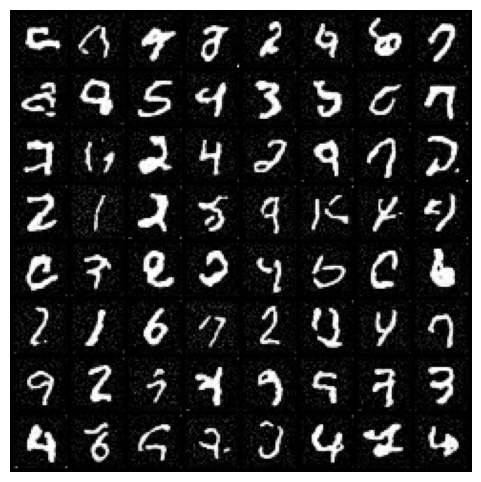

In [15]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


def visualize_samples(samples, batch_size=64):
    samples = samples.clamp(-1.0, 1.0) * 0.5 + 0.5

    sample_grid = make_grid(samples, nrow=int(np.sqrt(batch_size)))

    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.show()

sampler = EulerMaruyamaSampler(score_model, coef_calculator, device=device, eps=1e-4)
batch_size = 64

samples = sampler.sample(batch_size=batch_size, n_steps=700) # We use 700 steps
visualize_samples(samples, batch_size=batch_size)

The results seem to be quite good, but we needed about 700 inference steps to get there. Feel free to experiment with the number of steps and the $\epsilon$ to see how it affects the quality of the samples.

### ODE sampling
ODE sampling is very similar to the SDE sampling, but we make a smaller step and don't add the noise -- so instead of making two steps backward and one step forward, we do only one step backward. 

The formula for the reverse-time ODE, in our case, is:
$$
x_{t - \Delta t} = x_t  +  \Delta t\cdot \frac{g^2(t)}{2} \cdot s_\theta(x_t, \sqrt{a(t)}
$$

100%|██████████| 700/700 [00:01<00:00, 512.39it/s]


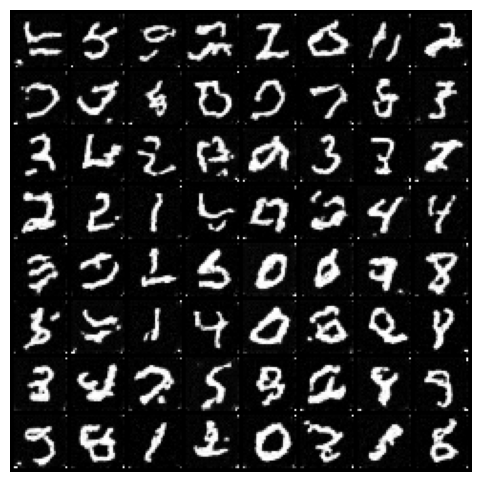

In [16]:
class EulerODESampler:
    def __init__(self, score_model, coef_calculator, device, eps=5e-3):
        self.score_model = score_model
        self.coef_calculator = coef_calculator
        self.device = device
        self.eps = eps

    def single_step_sample(self, x_t: torch.Tensor, t:  torch.Tensor, dt: torch.Tensor):
        """Assumes all inputs are on the same device and have the same batch size"""

        std = self.coef_calculator.get_noise_std(t)
        with torch.no_grad():
            score = self.score_model(x_t, std)

        g = coef_calculator.get_diffusion_coeff(t).view(-1, 1, 1, 1)
        dt = dt.view(-1, 1, 1, 1)

        return  x_t + dt * (g**2)/2 * score


    def sample(self, n_steps, batch_size=64):
        t_steps = torch.linspace(1.0, self.eps, n_steps, device=self.device)
        dt = t_steps[0] - t_steps[1]
        dt_batch = torch.ones(batch_size, device=device) * dt

        x_T = torch.randn(batch_size, 1, 28, 28, device=self.device) * self.coef_calculator.get_noise_std(1.0)
        x_t = x_T  # Initial state

        for t in tqdm(t_steps):
            t_batch = torch.ones(batch_size, device=device) * t # broadcasting t to the batch size
            x_t = self.single_step_sample(x_t, t_batch, dt_batch)

        return x_t

sampler = EulerODESampler(score_model, coef_calculator, device=device, eps=1e-4)
batch_size = 64

samples = sampler.sample(batch_size=batch_size, n_steps=700)
visualize_samples(samples, batch_size=batch_size)


Again I encourage you to experiment with the number of steps and the $\epsilon$ to see how it affects the quality of the samples. The results are okay but not as good as the SDE samples. It is because the ODE trajectories don't align fully with the distribution of the forward process, which adds up at each step and leads to worse samples.

# Consistency Distillation <a id="cdistillation"></a>

![consistency_models](images/consistency_models.png)

As discussed during the presentation, Consistency Models are trained to skip the sampling path along the ODE trajectory and instead predict the sample directly at the $t=0$ 

![consistency_models_inference](images/consistency_models_inference.png)


### Consistency Loss

ODE Diffusion model distillation is all about prediction consistency. We want to optimize for prediction consistency along the ODE trajectory. To do so, we sample one point from the ODE trajectory -- $x_t$ and we calculate the prediction of $x_\epsilon$ from this point. As a target for our network, we do a single step of the ODE trajectory from $x_t$ to $x_{next\_t}$ which has slightly smaller noise. We then we again predict the $x_\epsilon $ from $x_{next\_t}$ and minimize the difference between the two predictions. 

This is similar to the single-step Temporal Difference learning (in Reinforcement learning), in which we iteratively update the value function of one state based on the value function of the next state. Similarily here, we use the prediction temporally closer to the target distribution (smaller T, or `next_t` in our case) to update the prediction of the sample further away from the target distribution (larger T, or `t` in our case). Similarily to the TD learning, we don't want to penalize the prediction of the `next_t` prediction, as it is the target for the `t` prediction.

To obtain the image at `next_t` we can use a single step of the ODE sampler (using our score model). Thus we can ensure, that the image at `next_t` belongs to the same trajectory as the image at `t` (see the first image in this section). 

So, TLDR:
1. Sample $x_t$ from the dataset
1. Predict the $x_\epsilon$ from the $x_t$ using the trained Consistency Model (this is our prediction)
1. Sample $x_{next_t}$ from the ODE trajectory by using a single step of the ODE sampler (and the score model) 
1. Predict the $x_\epsilon$ from the $x_{next_t}$ using the Consistency Model with no gradient backpropagation (this is our target) 
1. Minimize the difference between the two predictions


![consistency_loss_example](images/consistency_loss_example.png)

The main idea is, that local consistency is not hard to achieve and if we are consistent along all the trajectory, we should be able to generate samples that are consistent with the original ODE model even starting from the most noisy points.

So the authors use a visual distance between two predictions of the $x_\epsilon$ conditioned on the $x_t$ and $x_{next\_t}$ as the main loss function. In the original paper they suggested that Learned Perceptual Image Patch Similarity ([LPIPS](https://arxiv.org/abs/1801.03924)) performs better than L2 as the visual distance loss. In my tests, LPIPS significantly slowed down the training, which made the training of the model impractical, so MSE was chosen for the notebook. I leave the commented code for LPIPS loss if anyone would want to experiment with it.

#### Regularisation losses
Aside from the L2 (MSE) consistency loss, we also use two additional regularization losses which help stabilize the learning 
1. the overflow loss, which penalizes the model for generating samples outsize of the "legal" range (in our case $[-1, 1]$) 
1. the mean loss, which penalizes the model for generating samples that are too far from the mean pixel value of the data. 


Lack of the overflow loss has lead the model to "wander" out of the legal distribution generating samples either fully dark or fully white. The overflow loss alone sometimes resulted in the model oscillating between noisy bright and noisy dark samples. Both losses can stabilise the learning -- especially with the Consistency Training

In [1]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS


class VisualLoss(nn.Module):
    def __init__(self, lpips_model='vgg', l2_weight=1.0, lpips_weight=0.0, overflow_weight=0.1, mean_weight=0.1, device='cuda'):
        super().__init__()
        self.lpips = LPIPS(net_type=lpips_model)
        self.lpips.to(device)

        self.l2_weight = l2_weight
        self.lpips_weight = lpips_weight
        self.overflow_weight = overflow_weight
        self.mean_weight = mean_weight

        self.target_mean = torch.tensor(-0.7, device=device)

    def forward_overflow(self, x):
        """Regularization: Prevent overflow by penalizing values outside of [-1, 1]"""
        with torch.no_grad():
            target = x.detach().clamp(-1.0, 1.0)

        return F.mse_loss(x, target)
    
    def forward_mean(self, x):
        """Regularization: Penalize the mean of the output for being far from the target mean"""
        return F.mse_loss(x.mean(), self.target_mean)

    @staticmethod
    def forward_l2(x, y):
        return F.mse_loss(x, y)

    def forward_scaled_lpips(self, x, y):
        x_prep = F.tanh(x).repeat(1,3,1,1)
        y_prep = F.tanh(y).repeat(1,3,1,1)

        return self.lpips(x_prep, y_prep)

    def forward(self, x, y):
        l2_loss = self.forward_l2(x, y)
        # lpips_loss = self.forward_scaled_lpips(x, y) # Uncomment to use LPIPS

        total_loss = self.l2_weight * l2_loss \
            + self.overflow_weight * self.forward_overflow(x) \
            + self.mean_weight * self.forward_mean(x) 
            # + self.lpips_weight * lpips_loss \ # Uncomment to use LPIPS

        return total_loss 


NameError: name 'nn' is not defined

### Defining the consistency model

The consistency model is very similar to the original model. In the original paper during the Consistency Distillation the model's weights were initialized from the base SDE diffusion model. This way the model already has some knowledge about how to denoise the distribution.


You might now notice, that if we just use a regular U-Net network for the consistency model, the model might just learn to ignore the input and output the same thing all the time. 

![consistency_loss_collapse](images/consistency_loss_collapse.png)

To prevent this, we constraint the model by parametrization. We scale the output in a way, that at $t=\epsilon$ the output is the same as the input ($x_\epsilon = x_{data}$). This way, the model at the next timestep will be forced to predict the same thing -- so $x_{data}$. As a result, the model is forced to learn to denoise the input. The authors suggested doing the scaling in a differentiable way based on the std at the given time point -- The paper doesn't specify how to do it, but this formulation of `c_out` and `c_skip` can be found in their code -- so we used the same formulation.

![consistency_model_parametrization](images/consistency_model_parametrization.png)

The output of the model is also scaled by $std^2$ (or $a^2(t)$ in our initial formulation) to exploit the fact that the model at the initialization should estimate the score, which during the score matching is trained as $argmin_{\theta} |s_{\theta}(x, t) * std + z|^2$. This way (hopefully) the model is able to converge faster.

In [18]:
import copy

class ConsistencyModel(nn.Module):
    def __init__(self, coef_calculator, std_epsilon, std_data=0.1, device='cuda', source_model=None):
        super().__init__()

        self.coef_calculator = coef_calculator

        if source_model is None:
            self.model = ScoreNet(coef_calculator=coef_calculator)
        else:
            self.model = copy.deepcopy(source_model)

        self.model = torch.nn.DataParallel(self.model)
        self.model.to(device)

        self.std_data = std_data
        self.std_epsilon = std_epsilon

    def get_c_out(self, std):
        return (self.std_data * (std - self.std_epsilon)) / (self.std_data**2 + std**2) ** 0.5

    def get_c_skip(self, std):
        return self.std_data**2 / ((std - self.std_epsilon) ** 2 + self.std_data**2)

    def forward(self, x_t, t):
        std = self.coef_calculator.get_noise_std(t)
        scaled_x_t   = x_t * self.get_c_skip(std).view(-1, 1, 1, 1) # Skip connection scaling

        out = self.model(x_t, std)
        out_scaling = self.get_c_out(std) * std**2 
        scaled_out = out * out_scaling.view(-1, 1, 1, 1)

        return scaled_x_t + scaled_out

To better understand the skip and out scales, let's visualize them!

In [19]:
cm = ConsistencyModel(coef_calculator, std_epsilon=1e-3, device=device)


t = torch.linspace(0, 1, 1000, device=device)

stds = coef_calculator.get_noise_std(t)

c_out  = cm.get_c_out(stds).detach().cpu().numpy()
c_skip = cm.get_c_skip(stds).detach().cpu().numpy()
t = t.cpu().numpy()

fig = line(x=t, y=c_out, title='c_out', labels={'x': 't', 'y': 'c_out'})
fig.show()

fig = line(x=t, y=c_skip, title='c_skip', labels={'x': 't', 'y': 'c_skip'})
fig.show()

### Moving target during the distillation
Approaches such as the Consistency Loss are prone to significant instability of training -- you update the model M based on the target, which is also calculated by the model M. This often leads to the model oscillation or output explosion. 

To prevent this, we can differentiate between the network that is being trained (Online network), which generates the $x_0$ predictions from images at time `t`, and the network used for generating the target (better) predictions conditioned on image at timepoint `next_t` (where `next_t` < `t`). The target network needs to be much more stable, but still needs to be able to adapt to the changes in the online network. 

The common method is to use the Exponential Moving Average (EMA) for this purpose. At each update, the target network is updated as follows:
$$
M'_{new} = \alpha \cdot M'_{old} + (1 - \alpha) \cdot M_{new}
$$
where $\alpha$ is a small number, e.g. 0.992. This way the model M' is slowly updated to be closer to the model M.

In [20]:
import copy

class ExpMovingAverageModel(nn.Module):
    def __init__(self, model, decay=0.992, device='cuda'):
        super().__init__()

        self.model = model
        self.decay = decay
        self.device = device

        self.ema_model = copy.deepcopy(model)
        self.ema_model.to(device)
        self.ema_model.eval()

        for param in self.ema_model.parameters():
            param.requires_grad = False

    def update_ema(self):
        with torch.no_grad():
            for ema_param, param in zip(self.ema_model.parameters(), self.model.parameters()):
                ema_param.data.mul_(self.decay).add_(param.data, alpha=1-self.decay)

    def forward(self, x, t):
        return self.ema_model(x, t)

### Logger and image tracker
The model takes forever to train, so we will use a simple logger to visualise generated samples during training -- we initialize the images at $t=1$ and then do the single step inference to see how the model improves.

In [21]:
import random
import string

from pathlib import Path


class PredictionLogger:
    def __init__(self, model, coef_calculator, device='cuda', base_image_dir="predictions", base_models_dir='models', name_length=6):
        self.model = model
        self.device = device

        experiment_name = ''.join(random.choices(string.ascii_uppercase + string.digits, k=name_length))
        print(f"Experiment name: {experiment_name}")

        self.base_image_dir = Path(base_image_dir) / experiment_name
        self.base_image_dir.mkdir(parents=True, exist_ok=True)

        self.base_models_dir = Path(base_models_dir) / experiment_name
        self.base_models_dir.mkdir(parents=True, exist_ok=True)

        self.base_y_T = torch.randn(64, 1, 28, 28, device=device) * coef_calculator.get_noise_std(1)

    def get_prediction(self):
        return self.model(self.base_y_T, torch.ones(64, device=self.device))

    def save_model(self):
        torch.save(self.model.state_dict(), self.base_models_dir / 'model.pth')

    def log_prediction(self, prediction_name):
        prediction = self.get_prediction()
        prediction = prediction.clamp(-1.0, 1.0) * 0.5 + 0.5

        sample_grid = make_grid(prediction, nrow=int(np.sqrt(64)))

        plt.figure(figsize=(6,6))
        plt.axis('off')
        plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
        plt.savefig(self.base_image_dir / f"{prediction_name}.png")
        
        plt.show()
        plt.close()

        print("image saved to ", self.base_image_dir / f"{prediction_name}.png")


### Time discretization
To simplify the distillation process the authors decided to discretize the time into a fixed number of intervals. Then the consistency model will not have to learn to understand the whole linear space of time, but only the specific discrete points.

In the original paper the authors suggested discretizing time using a [Karras et al 2022](https://arxiv.org/pdf/2206.00364.pdf) noise schedule to prioritize the quality of the generated samples at lower standard deviations. In our case achieve similar effect by randomly choosing the $t$ and then mapping it to random $\sqrt{a(t)}$. In my tests using the mentioned schedule caused large $\delta std$ between the time steps, which made the results worse. Because of that we sticked to the linear schedule.


In [22]:
class TimeDiscretizer:
    def __init__(self, num_discretization_steps, epsilon, device='cuda'):
        self.num_discretization_steps = num_discretization_steps
        self.max_t = 1.0
        self.epsilon = epsilon

        self.device = device

    def get_discrete_time_points(self, time_point_indices: np.ndarray):
        return torch.tensor(time_point_indices * (self.max_t - self.epsilon) / (self.num_discretization_steps - 1) + self.epsilon, device=self.device, dtype=torch.float32)


### Combining it all together
So now we build a trainer, that will use our `EulerODESampler` to calcualte the next discretized ODE trajectory point. Then we calculate the target for the consistency model and train it. We also update the moving target model. We also track the images and the loss.

The authors suggest, that having less discretization steps yields faster convergence, but might result in worse quality of the generated samples. They experimented with both Euler and Heun sampler and achieved best results with 18 steps with a Heun sampler. We use the much simpler Euler sampler, so we should use more steps to achieve similar results, but we will stick to 18 steps for the sake of training time (it still takes about 150 epochs before anything becomes visible).

In [23]:

from tqdm import tqdm


class Distillator:
    def __init__(self, dataloader, base_model, coef_calculator, time_discretizer, lr=1e-3, eps=1e-4, max_t=1.0, device='cuda'):
        self.dataloader = dataloader
        self.lr = lr

        self.eps = eps
        self.max_t = max_t

        self.coef_calculator = coef_calculator
        self.time_discretizer = time_discretizer

        self.device = device
        self.base_model = base_model
        self.base_model = self.base_model.to(device)

        std_epsilon = coef_calculator.get_noise_std(eps)

        self.online_model = ConsistencyModel(coef_calculator, std_epsilon, source_model=base_model, device=device)
        self.online_model = self.online_model.to(device)

        self.visual_loss = VisualLoss(device=device)
        self.optimizer = torch.optim.Adam(self.online_model.parameters(), lr=self.lr)

        self.ema_model = ExpMovingAverageModel(self.online_model, device=device)
        self.sampler = EulerODESampler(self.base_model, coef_calculator=coef_calculator, device=device, eps=eps)

        self.loss_history = []
        self.prediction_logger = PredictionLogger(self.ema_model, coef_calculator, device=device)

    def get_td_ema_estimations(self, x, current_t, next_t):
        """Compute the Temporal Difference EMA estimations of X_0 for a batch of data"""
        dt = current_t - next_t # will be always positive, but might vary between batch elements
        assert (dt > 0).all(), "Time is decreasing, but we keep dt positive"

        x_next_t = self.sampler.single_step_sample(x, current_t, dt) # x_(next_t) 
                                                                     # we do a single small step along the ODE trajectory based on the base model

        return self.ema_model(x_next_t, next_t) # Our target x_0 estimate

    def get_random_current_t_indices(self, batch_size):
        return np.random.randint(
            1,                                                  # We don't want to sample at t=0
            self.time_discretizer.num_discretization_steps,     # We don't want to sample at t=T, this param is one over the max value our randomizer can get
            size=batch_size
        )

    def consistency_distillation_loss(self, x_0):
        """Compute the distillation loss for a batch of x_0 data"""
        time_point_indices = self.get_random_current_t_indices(batch_size=x_0.shape[0])

        current_t = self.time_discretizer.get_discrete_time_points(time_point_indices)
        next_t = self.time_discretizer.get_discrete_time_points(time_point_indices - 1)

        # Prepare the perturbed images -- we need to add noise to the x_0 to get x_t
        current_sigma = self.coef_calculator.get_noise_std(current_t)
        noise = torch.randn_like(x_0) * current_sigma.view(-1, 1, 1, 1)
        x_t = x_0 + noise

        # We get our x_0 predictions by our trainable model and the target EMA estimations based on the next step 
        online_predictions = self.online_model(x_t, current_t)
        ema_estimations = self.get_td_ema_estimations(x_t, current_t, next_t)

        return self.visual_loss(online_predictions, ema_estimations)

    def train_single_epoch(self):
        self.online_model.train()

        self.loss_history.append([])
        for x, _ in self.dataloader:
            self.optimizer.zero_grad()

            x = x.to(device)

            loss = self.consistency_distillation_loss(x)
            loss.backward()

            self.optimizer.step()
            self.ema_model.update_ema()

            self.loss_history[-1].append(loss.item())


    def train(self, n_epochs):
        for epoch in tqdm(range(n_epochs), total=n_epochs):
            self.train_single_epoch()

            if epoch % 30 == 0:
                print(f"Epoch {epoch} loss: {np.mean(self.loss_history[-1])}", flush=True)
                self.prediction_logger.log_prediction(f"epoch_{len(self.loss_history)-1}_final")
                self.prediction_logger.save_model()

In [24]:
base_model = score_model

batch_size = 2048
epsilon = 2e-3
discretization_steps = 20 # 80 discretization steps worked best for Euler in the original paper but it's too slow for this notebook
lr = 4e-5

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(scale_to_minus_one_one),
    ])

dataset = MNIST('.', train=True, transform=transformations, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

time_discretizer = TimeDiscretizer(num_discretization_steps=discretization_steps, epsilon=epsilon, device=device)
distillator = Distillator(data_loader, base_model, time_discretizer=time_discretizer, coef_calculator=coef_calculator, eps=epsilon, lr=lr, device=device)

cd_ema_model_path    = Path('models/ema_model-best.pth')
cd_online_model_path = Path('models/online_model-best.pth')

Experiment name: 2EO52T


The models are already provided, so you can just run a single epoch training. If you want to train the model from scratch, you can remove/rename the models, or change the `load_cd_model` parameter to `False`. After that you can run the training loop. The number of epochs is set to 1 to demonstrate the training process, but when training from scratch it is better to set it to 400.

In [25]:
load_cd_models = True

if load_cd_models:
    if cd_ema_model_path.exists() and cd_online_model_path.exists():
        distillator.ema_model.load_state_dict(torch.load(cd_ema_model_path, map_location=device))
        distillator.online_model.load_state_dict(torch.load(cd_online_model_path, map_location=device))
        print("Loaded checkpoint models")
    else:
        raise ValueError(f'Base model not found at {cd_ema_model_path} or {cd_online_model_path}, please set load_cd_models to False to train the model from scratch.')

Loaded checkpoint models


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0 loss: 0.0032815377460792662


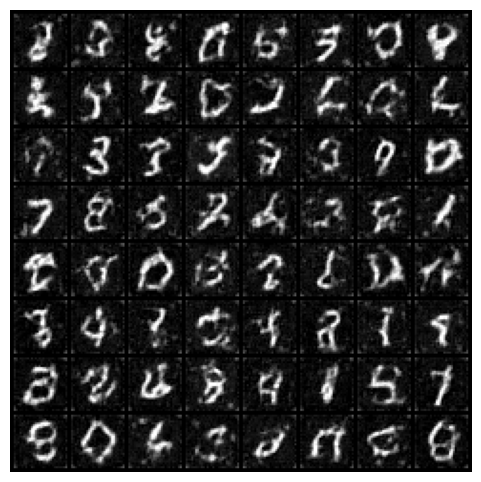

100%|██████████| 1/1 [00:13<00:00, 13.22s/it]

image saved to  predictions\2EO52T\epoch_0_final.png


In [26]:
distillator.train(1) # 400

In [27]:
# Save the models

torch.save(distillator.ema_model.state_dict(), cd_ema_model_path)
torch.save(distillator.online_model.state_dict(), cd_online_model_path)

## Multistep sampling <a id="multistep"></a>

![multistep_sampling](images/multistep_sampling.png)



Now the model should be able to jump from any **discretized** point to $x_0$, but the longer the route, the worse the quality of the samples (as we optimize for local consistency). The authors suggested that we can use the model to sample from the $t=1$ and then noise the output to simulate anouther $x_t$. Then we can predict the $x_0$ again, but with better quality.

Remember that we trained our model to predict the sample at $t=0$ from the sample at any **discrete** point -- We simplified the task during the training, so that the model doesn't have to be able to interpret the whole continuous temporal space, but only the specific points. This needs to be taken into account during the multistep sampling -- we can only choose those points that were used during the training. To address that, we use `num_steps` evenly distributed discretized time points, with `num_steps` being the number of steps during the inference.

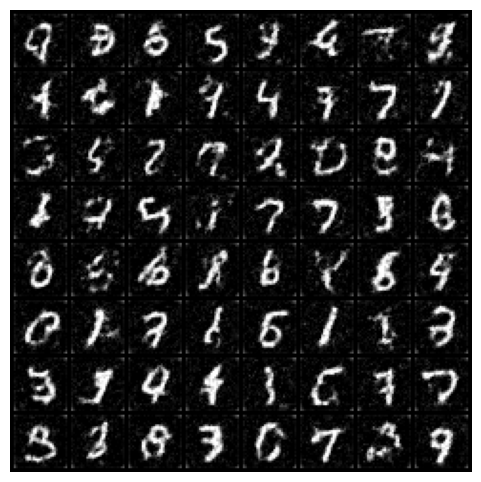

In [28]:
class MultiStepSampler:
    def __init__(self, consistency_model, coef_calculator, time_discretizer, eps, device='cuda'):
        self.consistency_model = consistency_model
        self.coef_calculator = coef_calculator
        self.time_discretizer = time_discretizer
        self.device = device
        self.eps = eps

    def get_random_x_T(self):
        return torch.randn(64, 1, 28, 28, device=self.device) * self.coef_calculator.get_noise_std(1)

    def get_time_sequence(self, num_steps):

        # We select from num_discretization_steps - 2 to 1, as we don't want to sample at t=T or t=epsilon
        time_indices = np.linspace(self.time_discretizer.num_discretization_steps - 2, 1, num_steps, dtype=int)

        # note that we use linspace to get linearly distributed indices, 
        # but we need to convert them to indices by setting the dtype to int

        return self.time_discretizer.get_discrete_time_points(time_indices)

    def get_t_vector(self, t: float, batch_size: int):
        """Transforms a scalar t to a vector of size batch_size with the same value"""
        return torch.ones(batch_size, device=self.device) * t
    
    def sample(self, num_steps, x_T=None):
        if x_T == None:
            x_T = self.get_random_x_T()

        batch_size=x_T.shape[0]

        x_0 = self.consistency_model(x_T, self.get_t_vector(1.0, batch_size=batch_size))

        if (num_steps > 1):
            for t in self.get_time_sequence(num_steps):
                x_0 = x_0.clamp(-1.0, 1.0) 
                
                noise_coef = self.coef_calculator.get_noise_std(t)
                noise = torch.randn_like(x_0, device=device) * noise_coef.view(-1, 1, 1, 1)
        
                x_t = x_0 + noise #+ torch.sqrt(t**2 - self.eps**2 + 1e-8) #* noise

                x_0 = self.consistency_model(x_t, self.get_t_vector(t, batch_size=batch_size))

        return x_0


num_steps=2

samples = sampler.sample(num_steps)
visualize_samples(samples, batch_size=samples.shape[0])

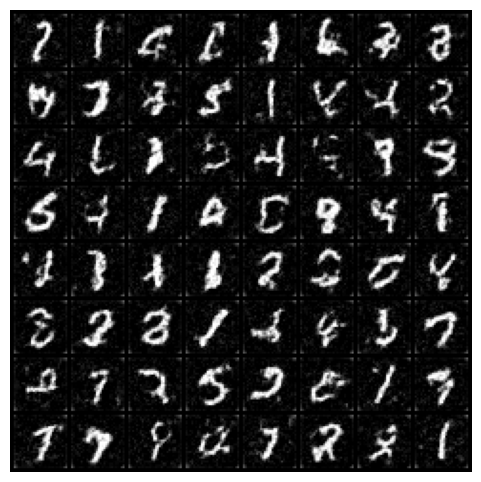

In [29]:
num_steps=3

samples = sampler.sample(num_steps)
visualize_samples(samples, batch_size=samples.shape[0])

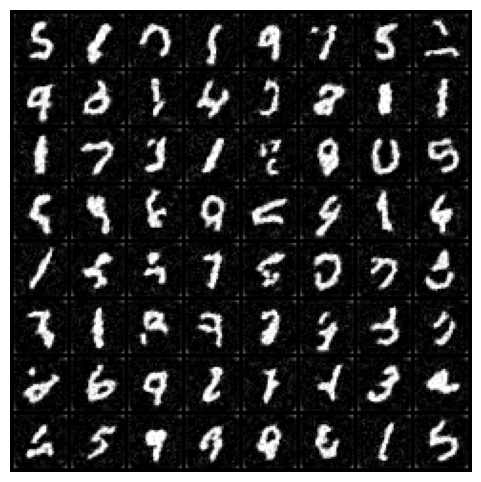

In [30]:
num_steps=20 # We have 20 discretization steps, so going beyond that would be meaningless

samples = sampler.sample(num_steps)
visualize_samples(samples, batch_size=samples.shape[0])

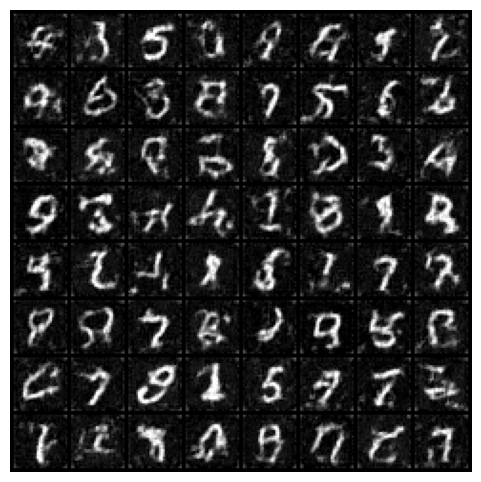

In [31]:
num_steps=1 # Single step inference for comparison

samples = sampler.sample(num_steps)
visualize_samples(samples, batch_size=samples.shape[0])

In the tests of multistep sampling, using 2 or 3 steps yielded significantly better results than single-step sampling. Using more than 4-5 steps usually lead to the model generating samples with clearer edges -- almost binary, as in the original dataset. The subjective quality of the samples above 3-4 samples did not improve significantly. 

## Consistency training <a id="ctraining"></a>

Consistency models can be also trained without the baseline ODE model. Instead of acquiring the $x_{t - \Delta t}$ from the ODE model, they just reuse the perturbation noise $z\cdot\sqrt{a(t)}$ where $z \in\mathcal{N}(0,1)$  of $x_t$ and construct $x_{t - \Delta t}$ by adding smaller $z\cdot\sqrt{a(t - \Delta t)}$.

The main intuition is to create theoretical ODE trajectories, on which for each image at timepoint `t`, which is constructed as $x_0 + \alpha \cdot z$ the image at timepoint `next_t` can be constructed as $x_0 + \beta \cdot z$ where $\alpha > \beta$ -- So on such a trajectory, the noise added to the image simply scales linearly over time. This though should be treated only as an initial intuition -- the authors provided a full theoretical proof of the method in the paper, which is beyond the scope of this notebook.


This approach could take significantly longer to converge, but doesn't require the score model to be trained first.


In [32]:

from tqdm import tqdm


class ConsistencyTrainer:
    def __init__(self, dataloader, coef_calculator, time_discretizer, lr=1e-3, eps=1e-4, max_t=1.0, device='cuda'):
        self.dataloader = dataloader
        self.lr = lr

        self.eps = eps
        self.max_t = max_t

        self.coef_calculator = coef_calculator
        self.time_discretizer = time_discretizer

        self.device = device

        sigma_epsilon = coef_calculator.get_noise_std(eps)
        sigma_T = coef_calculator.get_noise_std(max_t)

        self.online_model = ConsistencyModel(coef_calculator, sigma_epsilon, sigma_T, device=device)
        self.online_model = self.online_model.to(device)

        self.visual_loss = VisualLoss(device=device)
        self.optimizer = torch.optim.Adam(self.online_model.parameters(), lr=self.lr)

        self.ema_model = ExpMovingAverageModel(self.online_model, device=device)

        self.loss_history = []
        self.prediction_logger = PredictionLogger(self.ema_model, coef_calculator, device=device)

    def get_random_current_t_indices(self, batch_size):
        return np.random.randint(
            1,                                                  # We don't want to sample at t=0
            self.time_discretizer.num_discretization_steps,     # We don't want to sample at t=T, this is one over the max random value
            size=batch_size
            )

    def consistency_loss(self, x_0):
        """Compute the distillation loss for a batch of data"""
        time_point_indices = self.get_random_current_t_indices(batch_size=x_0.shape[0])

        current_t = self.time_discretizer.get_discrete_time_points(time_point_indices)
        next_t = self.time_discretizer.get_discrete_time_points(time_point_indices - 1)

        assert (next_t < current_t).all(), "Time must be decreasing"

        z = torch.randn_like(x_0, device=self.device)

        current_std = self.coef_calculator.get_noise_std(current_t)
        noise_t = z * current_std.view(-1, 1, 1, 1)
        x_t = x_0 + noise_t

        next_std = self.coef_calculator.get_noise_std(next_t)
        noise_next_t = z * next_std.view(-1, 1, 1, 1)
        x_next_t = x_0 + noise_next_t # We don't use the ODE sampler here as in Consistency Distillation, 
                                      # we just scale the noise differently

        online_predictions = self.online_model(x_t, current_t)
        ema_estimations = self.ema_model(x_next_t, next_t)

        return self.visual_loss(online_predictions, ema_estimations)

    def train_single_epoch(self):
        self.online_model.train()

        self.loss_history.append([])
        for x, _ in self.dataloader:
            self.optimizer.zero_grad()

            x = x.to(device)

            loss = self.consistency_loss(x)
            loss.backward()

            self.optimizer.step()
            self.ema_model.update_ema()

            self.loss_history[-1].append(loss.item())


    def train(self, n_epochs):
        for epoch in (pbar := tqdm(range(n_epochs), total=n_epochs)):
            self.train_single_epoch()
            if epoch % 30 == 0:
                self.prediction_logger.log_prediction(f"epoch_{len(self.loss_history)-1}_final")
                self.prediction_logger.save_model()
            
            pbar.set_description(f"Loss: {np.array(self.loss_history[-1]).mean():.5f}")


In [34]:

batch_size = 4096
epsilon = 5e-3
discretization_steps = 20 
lr = 1e-4
load_ct_models = True

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(scale_to_minus_one_one),
    ])

dataset = MNIST('.', train=True, transform=transformations, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

time_discretizer = TimeDiscretizer(num_discretization_steps=discretization_steps, epsilon=epsilon, device=device)

consistency_trainer = ConsistencyTrainer(data_loader, time_discretizer=time_discretizer, coef_calculator=coef_calculator, eps=epsilon, lr=lr, device=device)


ct_ema_model_path    = Path('models/ct-ema.pth')
cd_online_model_path = Path('models/ct-online.pth')

if load_ct_models:
    if ct_ema_model_path.exists() and cd_online_model_path.exists():
        consistency_trainer.ema_model.load_state_dict(torch.load(ct_ema_model_path, map_location=device))
        consistency_trainer.online_model.load_state_dict(torch.load(cd_online_model_path, map_location=device))
        print("Loaded checkpoint models")
    else:
        raise ValueError(f'Base model not found at {ct_ema_model_path} or {cd_online_model_path}, please set load_ct_models to False to train the model from scratch.')


Experiment name: 633V5Y
Loaded checkpoint models


Training the CT model can take very long time (the model in the repository took about 2 days to train, with progressively reducing the learning rate). To avoid any runtime issues, we will save both models every 30 epochs. 

To perform the full training instead of just a demonstration, you can set the `load_ct_model` to `False` and run the training loop. Otherwise you can just load the models, perform a single epoch of training (for demonstration) and see the results.

Training batch 0/1


  0%|          | 0/1 [00:00<?, ?it/s]

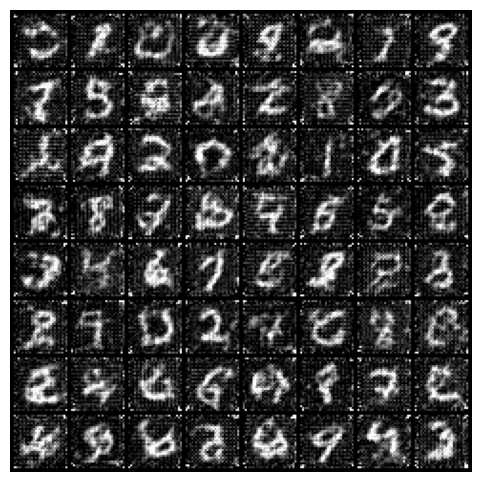

Loss: 0.01628: 100%|██████████| 1/1 [00:16<00:00, 16.53s/it]

image saved to  predictions\633V5Y\epoch_1_final.png


In [39]:

if load_ct_models: # We perform just a demonstration of the training
    training_epochs = 1
    total_incremental_trainings = 1
else:
    training_epochs = 30
    total_incremental_trainings = 80 # 80 incremental trainings, each with 30 epochs


for i in range(total_incremental_trainings):
    print(f"Training batch {(i)*training_epochs}/{total_incremental_trainings*training_epochs}")
    
    consistency_trainer.train(training_epochs)

    torch.save(consistency_trainer.ema_model.state_dict(), ct_ema_model_path)
    torch.save(consistency_trainer.online_model.state_dict(), cd_online_model_path)

### Multistep samping with Consistency Training model
And again we can see how it performs in the multi-step sampling. The results are not as good as the ODE model, but still quite good. The model is able to generate samples that are consistent with the original ODE model even starting from the most noisy points.

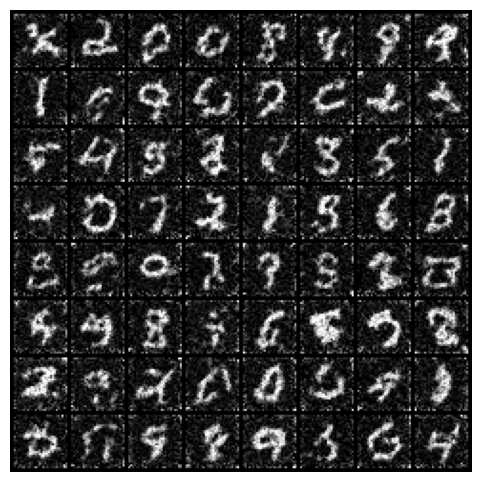

In [36]:
num_steps=4

sampler = MultiStepSampler(
    consistency_model=consistency_trainer.ema_model,
    coef_calculator=coef_calculator,
    time_discretizer=time_discretizer,
    eps=epsilon,
    device=device)


samples = sampler.sample(num_steps)

visualize_samples(samples, batch_size=samples.shape[0])

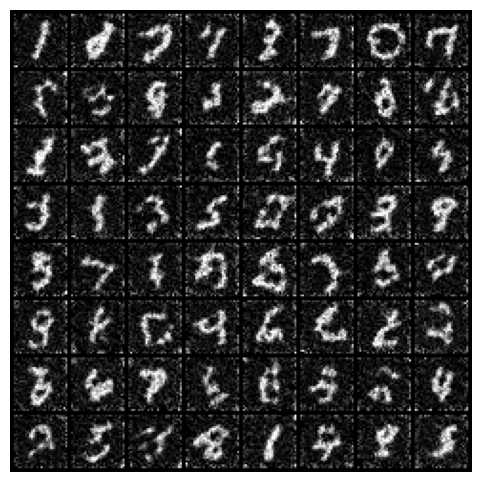

In [37]:
num_steps=10

samples = sampler.sample(num_steps)
visualize_samples(samples, batch_size=samples.shape[0])

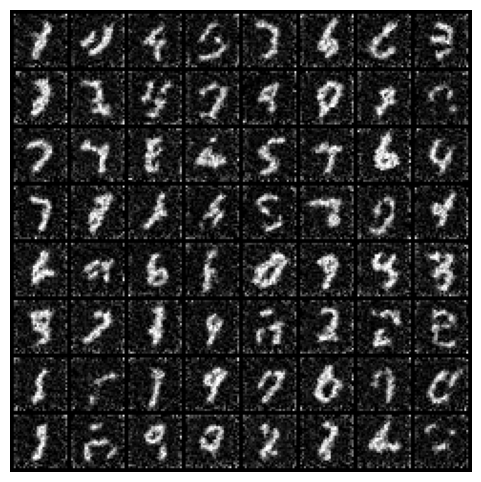

In [38]:
num_steps=20

samples = sampler.sample(num_steps)
visualize_samples(samples, batch_size=samples.shape[0])

Similarly to Consistency Distillation, multistep sampling can also improve the results of the Consistency Training model. 

As the model was still undertrained (even after about 2000 epochs), some noise artifacts are still visible in the background. Nevertheless, the results seem to be quite good.

# Conclusions <a id="conclusion"></a>
In this work, we explored the core ideas of the paper ["Consistency Models" by Yang Song et al.](https://arxiv.org/pdf/2303.01469.pdf) Specifically:
- Consistency Distillation (CD)
- Consistency Training (CT)
- Multistep sampling

Consistency Models are a very interesting approach to the problem of long inference time with continuous time diffusion models. The results they achieve (especially with proper training and a good base model) can be very impressive. The method is also very flexible -- it can be easily applied to non-continuous time diffusion models. I found the method to be very interesting due to its use of temporally-local consistency with small constraints to achieve high quality global consistency. It was also very insightful to see the application of Reinforcement Learning concepts in the context of generative models.

I sure hope that distillation of diffusion models for faster inference might become a standard practice in the future. I am afraid though, that the complexity of the training and its significant duration (greatly longer than the convergence of the base score model) might be a considerable issue for this approach. 

Recently Stable Diffusion released their [SDXL-Turbo](https://static1.squarespace.com/static/6213c340453c3f502425776e/t/65663480a92fba51d0e1023f/1701197769659/adversarial_diffusion_distillation.pdf) paper, which also aims for the distillation of large diffusion models. It suggests, that the demand for less computationally-intensive image generation is very high and that the research interest in the diffusion models distillation is growing.

Bartłomiej Pogodziński